In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import lightgbm
from itertools import product
from sklearn.preprocessing import LabelEncoder
import gc
import pickle

In [89]:
items = pd.read_csv('../sale-prediction/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv('../sale-prediction/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
cats = pd.read_csv('../sale-prediction/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
train = pd.read_csv('../sale-prediction/sales_train.csv', parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test = pd.read_csv('../sale-prediction/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}).set_index('ID')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [90]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
#かぶっている店の名前を変更。ほかにもあって気がするが。
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']] #この二つだけにしちゃうんだ
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [91]:
train = train.join(items, on='item_id', rsuffix='_')
train = train.join(shops, on='shop_id', rsuffix='_')
train = train.join(cats, on='item_category_id', rsuffix='_')
train = train.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,type_code,subtype_code
0,2013-02-01,0,59,22154,999.000000,1,37,30,11,1
1,2013-03-01,0,25,2552,899.000000,1,58,13,13,27
2,2013-05-01,0,25,2552,899.000000,-1,58,13,13,27
3,2013-06-01,0,25,2554,1709.050049,1,58,13,13,27
4,2013-01-15,0,25,2555,1099.000000,1,56,13,13,3
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,55,13,13,2
2935845,2015-09-10,33,25,7460,299.000000,1,55,13,13,2
2935846,2015-10-14,33,25,7459,349.000000,1,55,13,13,2
2935847,2015-10-22,33,25,7440,299.000000,1,57,13,13,8


In [92]:
train = train.query('item_price > 0')

In [93]:
train_monthly = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
train_monthly.columns = ['item_cnt_month'].clip(0,20).astype(np.float16)
train_monthly.reset_index(inplace=True)
train_monthly = train_monthly.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_')
train_monthly.drop(['item_id_','shop_id_','item_category_id_'], axis=1, inplace=True)
train_monthly

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,city_code,type_code,subtype_code
0,0,2,27,1,19,0,5,10
1,0,2,33,1,37,0,11,1
2,0,2,317,1,45,0,12,23
3,0,2,438,1,45,0,12,23
4,0,2,471,2,49,0,12,39
...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6,83,30,19,64
1609120,33,59,22088,2,83,30,19,64
1609121,33,59,22091,1,83,30,19,64
1609122,33,59,22100,1,42,30,12,19


In [94]:
test['date_block_num'] = 34
test = test.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_')

In [95]:
shop_ids = pd.concat([train_monthly['shop_id'],test['shop_id']], ignore_index=True, sort=False).unique()
item_ids = pd.concat([train_monthly['item_id'],test['item_id']], ignore_index=True, sort=False).unique()
empty_df = [[i, shop, item] for i in range(35) for shop in shop_ids for item in item_ids]
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
empty_df
# model-stacking-feature-engineering-and-edaより

,date_block_num,shop_id,item_id
0,0,2,27
1,0,2,33
2,0,2,317
3,0,2,438
4,0,2,471
...,...,...,...
44229145,34,36,15033
44229146,34,36,7572
44229147,34,36,9030
44229148,34,36,1867


In [96]:
matrix_df = empty_df.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_')
matrix_df.drop(['item_id_','shop_id_','item_category_id_'], axis=1, inplace=True)
matrix_df

,date_block_num,shop_id,item_id,item_category_id,city_code,type_code,subtype_code
0,0,2,27,19,0,5,10
1,0,2,33,37,0,11,1
2,0,2,317,45,0,12,23
3,0,2,438,45,0,12,23
4,0,2,471,49,0,12,39
...,...,...,...,...,...,...,...
44229145,34,36,15033,49,16,12,39
44229146,34,36,7572,64,16,14,42
44229147,34,36,9030,40,16,11,4
44229148,34,36,1867,31,16,8,61


In [97]:
matrix = pd.merge(matrix_df, train_monthly[['date_block_num','shop_id','item_id','item_cnt_month']],
                  on=['date_block_num','shop_id','item_id'], how='left')
reduce_mem_usage(matrix)

Memory usage of dataframe is 2362.09 MB
Memory usage after optimization is: 759.24 MB
Decreased by 67.9%


,date_block_num,shop_id,item_id,item_category_id,city_code,type_code,subtype_code,item_cnt_month
0,0,2,27,19,0,5,10,1.0
1,0,2,33,37,0,11,1,1.0
2,0,2,317,45,0,12,23,1.0
3,0,2,438,45,0,12,23,1.0
4,0,2,471,49,0,12,39,2.0
...,...,...,...,...,...,...,...,...
44229145,34,36,15033,49,16,12,39,NaN
44229146,34,36,7572,64,16,14,42,NaN
44229147,34,36,9030,40,16,11,4,NaN
44229148,34,36,1867,31,16,8,61,NaN


In [100]:
matrix = matrix[matrix.date_block_num < 34]
matrix = pd.concat([matrix, test], sort=False, ignore_index=True)
reduce_mem_usage(matrix)

Memory usage of dataframe is 2388.40 MB
Memory usage after optimization is: 658.87 MB
Decreased by 72.4%


,date_block_num,shop_id,item_id,item_category_id,city_code,type_code,subtype_code,item_cnt_month,item_id_,shop_id_,item_category_id_
0,0,2,27,19,0,5,10,1.0,NaN,NaN,NaN
1,0,2,33,37,0,11,1,1.0,NaN,NaN,NaN
2,0,2,317,45,0,12,23,1.0,NaN,NaN,NaN
3,0,2,438,45,0,12,23,1.0,NaN,NaN,NaN
4,0,2,471,49,0,12,39,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43179655,34,45,18454,55,20,13,2,NaN,18448.0,45.0,55.0
43179656,34,45,16188,64,20,14,42,NaN,16192.0,45.0,64.0
43179657,34,45,15757,55,20,13,2,NaN,15760.0,45.0,55.0
43179658,34,45,19648,40,20,11,4,NaN,19648.0,45.0,40.0


In [102]:
matrix.drop(['item_id_', 'shop_id_','item_category_id_'], axis=1, inplace=True)

In [103]:
matrix.to_pickle('matrix.pkl')
del train_monthly
del empty_df
del matrix_df
del shop_ids
del item_ids
gc.collect();

In [104]:
def lag_features(df, lags, target):
    for i in lags:
        df[str(target) + '_lag_' + str(i)] = df.groupby(['item_id','shop_id'])[target].shift(i)
    return df

In [105]:
ts = time.time()
matrix = lag_features(matrix, [1,2,3,6,12], 'item_cnt_month')

In [106]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'],how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', axis=1, inplace=True)

In [107]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [108]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [109]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12],'date_cat_avg_item_cnt')
matrix.drop('date_cat_avg_item_cnt', axis=1, inplace=True)

In [110]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [111]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)


In [112]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [113]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [114]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)


In [115]:
group = matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [116]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

1066.3958423137665

In [117]:
reduce_mem_usage(matrix)

Memory usage of dataframe is 3047.27 MB
Memory usage after optimization is: 3047.27 MB
Decreased by 0.0%


,date_block_num,shop_id,item_id,item_category_id,city_code,type_code,subtype_code,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,27,19,0,5,10,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,37,0,11,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,317,45,0,12,23,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,438,45,0,12,23,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,471,49,0,12,39,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43179655,34,45,18454,55,20,13,2,NaN,1.0,NaN,...,1.283203,1.338867,1.446289,1.197266,1.189453,1.197266,1.458984,1.0,1.329102,1.350586
43179656,34,45,16188,64,20,14,42,NaN,NaN,NaN,...,1.406250,1.380859,1.613281,1.000000,1.564453,1.000000,1.458984,NaN,2.742188,1.328125
43179657,34,45,15757,55,20,13,2,NaN,NaN,NaN,...,1.283203,1.338867,1.446289,1.197266,1.189453,1.197266,1.458984,NaN,1.329102,1.350586
43179658,34,45,19648,40,20,11,4,NaN,NaN,NaN,...,1.614258,1.727539,1.782227,1.269531,1.209961,1.269531,1.458984,NaN,1.617188,1.623047


In [118]:
matrix.to_pickle('matrix.pickle')

In [119]:
del matrix
del group
gc.collect();

In [120]:
matrix = pd.read_pickle('../sale-prediction写経/matrix.pickle')

In [121]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)


In [122]:
group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [123]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [124]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)
# 欠損を埋めている

In [125]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [126]:
train['revenue'] = train.item_price * train.item_cnt_day
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
#その月のショップごとの売り上げの合計

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float16)

C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float16)


In [128]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

In [129]:
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

In [130]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
#最初に売られた月ってこうやって出すんだ
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [131]:
matrix.to_pickle('matrix.pickle')

In [132]:
matrix['year'] = matrix['date_block_num']//12 + 2013
matrix['month'] = matrix['date_block_num'] % 12

In [133]:
matrix.to_pickle('matrix.pickle')

In [134]:
matrix = matrix[matrix.date_block_num > 11]

In [135]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

In [136]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'city_code',
       'type_code', 'subtype_code', 'item_cnt_month', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'dat

In [137]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28015380 entries, 15164280 to 43179659
Data columns (total 42 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_category_id                      int8   
 4   city_code                             int8   
 5   type_code                             int8   
 6   subtype_code                          int8   
 7   item_cnt_month                        float16
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_i

In [138]:
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [139]:
matrix.to_pickle('data.pkl')
del matrix

In [140]:
data = pd.read_pickle('data.pkl')

In [141]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'city_code',
       'type_code', 'subtype_code', 'item_cnt_month', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'dat

In [142]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [143]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [144]:
del data
gc.collect();

In [149]:
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'month', 'type_code', 'subtype_code']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          'max_depth': 8,
          "learning_rate" : 0.07,
          }

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=100)

time.time() - ts

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.810772	valid_1's rmse: 2.431
Early stopping, best iteration is:
[13]	training's rmse: 1.20711	valid_1's rmse: 2.07474


254.86579728126526

In [150]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_sub.csv', index=False)
# 1.84009

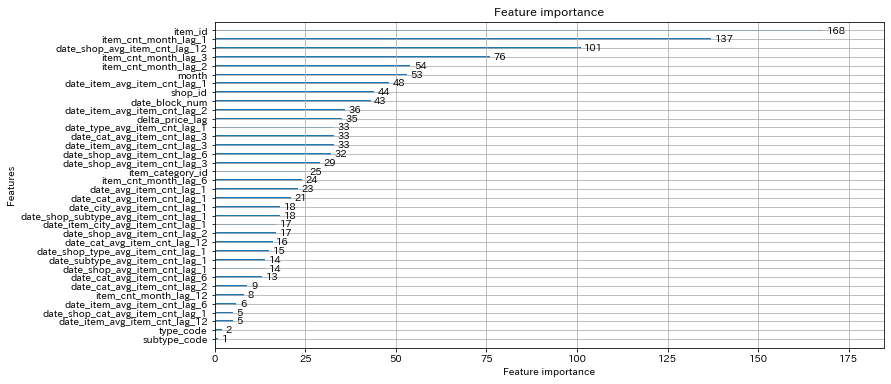

In [151]:
lightgbm.plot_importance(model, figsize=(12, 6))